In [0]:
!pip install mtcnn
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import scipy.io
import dlib
import mtcnn
from mtcnn.mtcnn import MTCNN
import pickle
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D,AveragePooling2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D, concatenate
from keras import models
from keras.models import Model, Sequential
import tensorflow as tf
from keras.utils import np_utils
from keras import regularizers
import operator

     |████████████████████████████████| 2.3MB 2.8MB/s 
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257690 sha256=3440bceb28f859272f8f8eb41a87e6854573c028438dd933ffdf2642c3eef7d0
  Stored in directory: /root/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn


Using TensorFlow backend.


In [0]:
"""Define functions to create the triplet loss with online triplet mining."""

import tensorflow as tf


def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.

    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.

    We generate all the valid triplets and average the loss over the positive ones.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
  #  assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
   # assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets


def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss
  
def batch_all(labels, embeddings, margin, squared=False):
  

  """Build the triplet loss over a batch of embeddings.

  For each anchor, we get the hardest positive and hardest negative to form a triplet.

  Args:
      labels: labels of the batch, of size (batch_size,)
      embeddings: tensor of shape (batch_size, embed_dim)
      margin: margin for triplet loss
      squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
               If false, output is the pairwise euclidean distance matrix.

  Returns:
      triplet_loss: scalar tensor containing the triplet loss
  """
  # Get the pairwise distance matrix
  pairwise_dist = _pairwise_distances(embeddings, squared=squared)

  # For each anchor, get the hardest positive
  # First, we need to get a mask for every valid positive (they should have same label)
  mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
  mask_anchor_positive = tf.to_float(mask_anchor_positive)

  # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
  anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

  # shape (batch_size, 1)
  #hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
  #tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

  # For each anchor, get the hardest negative
  # First, we need to get a mask for every valid negative (they should have different labels)
  mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
  mask_anchor_negative = tf.to_float(mask_anchor_negative)

  # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
  max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
  anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

  # shape (batch_size,)
 # hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
#  tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

  # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
  triplet_loss = tf.maximum(tf.reduce_mean(anchor_positive_dist) - tf.reduce_mean(anchor_negative_dist) + margin,0)

  # Get final mean triplet loss
  triplet_loss = tf.reduce_mean(triplet_loss)

  return triplet_loss

In [0]:
def adjust_gamma(image, gamma=1.0):
   invGamma = 1.0 / gamma
   table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
   return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [0]:
def alphabeta(image , alpha =1.0 ,beta = 0.0):
  for y in range(image.shape[0]):
      for x in range(image.shape[1]):
          for c in range(image.shape[2]):
              new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
  return new_image

In [0]:
class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=224, desiredFaceHeight=224):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, keypoints):
        # convert the landmark (x, y)-coordinates to a NumPy array
        #shape = self.predictor(gray, rect)
        #shape = shape_to_np(shape)

        # extract the left and right eye (x, y)-coordinates
        #(lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
        #(rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
        #leftEyePts = shape[lStart:lEnd]
        #rightEyePts = shape[rStart:rEnd]

        # compute the center of mass for each eye
        #leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        #rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
        leftEyeCenter = keypoints['left_eye']
        rightEyeCenter = keypoints['right_eye']

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) #- 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
 
        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
 
        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])
        
        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)
 
        # return the aligned face
        return output

In [0]:
def preProcessLoad(image,detector,faceAligner):
  #image = cv2.imread(imagePath)
  rects = detector.detect_faces(image)
  if len(rects) == 1  :
    faceAligned = faceAligner.align(image, rects[0]['keypoints'])
    return faceAligned
  else:
    return image

In [0]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
#file_name = "/content/original images.zip"
file_name = "/content/metadata.zip"
#/content/metadata.zip
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    #zip.printdir() 
  
    # extracting all the files 
    zip.extractall()  

In [0]:
mat = scipy.io.loadmat("/content/metadata/metadata.mat")

In [0]:
type(mat)

dict

In [0]:
mat

{'__globals__': ['metadata'],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Dec 12 01:50:37 2016',
 '__version__': '1.0',
 'metadata': array([[(array([[array(['AbdA'], dtype='<U4')]], dtype=object), array([[array(['00001'], dtype='<U5')]], dtype=object), array(['m'], dtype='<U1'), array([[31]], dtype=uint8), array(['i'], dtype='<U1'), array(['fr'], dtype='<U2'), array([[0]], dtype=uint8), array([[1]], dtype=uint8), array([[2016]], dtype=uint16), array(['2'], dtype='<U1'), array([[1]], dtype=uint8), array([[0]], dtype=uint8), array([[336.5       , 171.77272727, 350.31818182, 172.5       ,
         325.59090909, 174.68181818, 284.13636364, 174.68181818,
         296.5       , 175.40909091, 271.04545455, 176.13636364,
         338.68181818, 231.40909091, 288.5       , 233.59090909,
         313.95454545, 229.22727273, 312.5       , 243.77272727,
         361.95454545, 168.13636364, 257.95454545, 170.31818182,
         312.5       , 270.68181818, 311.77272727, 10

In [0]:
info  = mat["metadata"]

In [0]:
info[0][0][16] # illumuination type , 1 is well illuminated, 0  is badly illuminated

array([[1]], dtype=uint8)

In [0]:
info[0][0][17]

array([[array(['AbdA_00001_m_31_*'], dtype='<U17')]], dtype=object)

In [0]:
dictionary = {}
directory = '/content/original images'
path = directory
count = 0
path_iter = os.listdir(directory)
for i in path_iter:
  print(i)
  count += 1
  x = i.split('_')
 # break
  if x[0] in dictionary:
     dictionary[x[0]] += 1 
  else:
    dictionary[x[0]] = 1 
  

MahM_01261_m_26_i_fr_nc_sr_2016_2_e0_nl_o.jpg
HedA_00843_m_46_o_fr_nc_no_2016_1_e0_nl_o.jpg
BelA_00726_m_21_i_nf_nc_sd_2015_1_e0_nl_o.jpg
MerM_01428_f_20_i_fr_nc_hp_2016_2_e0_nl_o.jpg
OliA_02069_f_20_i_fr_nc_hp_2016_2_e0_nl_o.jpg
BahA_00593_m_36_i_fr_nc_no_2016_2_e0_nl_o.jpg
MerM_01417_f_20_i_fr_nc_no_2016_2_e0_nl_o.jpg
MahM_01177_m_26_i_fr_nc_sd_2016_2_e0_nl_o.jpg
HitS_00848_m_25_i_nf_nc_no_2015_1_e0_nl_o.jpg
BelA_00728_m_21_o_nf_nc_sd_2015_1_e0_nl_o.jpg
YosB_02495_f_20_i_fr_nc_hp_2016_2_e0_nl_o.jpg
SarE_02323_f_22_i_nf_nc_hp_2016_2_e0_nl_o.jpg
AboA_00189_m_33_i_fr_nc_sr_2016_2_e0_nl_o.jpg
OliA_02053_f_19_i_fr_nc_hp_2015_1_e0_nl_o.jpg
YosB_02606_f_20_i_fr_nc_sd_2016_2_e0_nl_o.jpg
MohG_01751_m_32_i_fr_nc_no_2016_2_e0_nl_o.jpg
MerK_01377_f_20_o_nf_nc_no_2015_1_e0_nl_o.jpg
OliA_02057_f_20_i_fr_nc_no_2016_2_e0_nl_o.jpg
MahA_00921_m_28_i_fr_nc_no_2016_2_e0_nl_o.jpg
MahM_01119_m_26_i_fr_nc_hp_2016_2_e0_nl_o.jpg
AboA_00182_m_33_i_fr_nc_no_2016_2_e0_nl_o.jpg
MazR_01333_m_24_o_nf_nc_hp_2015_1_

In [0]:
print(len(dictionary.keys()))
print(sum(dictionary.values()))
dictionary.keys()

112
2662


dict_keys(['MahM', 'HedA', 'BelA', 'MerM', 'OliA', 'BahA', 'HitS', 'YosB', 'SarE', 'AboA', 'MohG', 'MerK', 'MahA', 'MazR', 'AbdA', 'AsmH', 'NasH', 'AhmN', 'AlaG', 'MeiH', 'MirM', 'PetK', 'AndM', 'RehM', 'MarS', 'YouA', 'MahS', 'MyrM', 'EbrK', 'AlyM', 'BesA', 'AheG', 'MarG', 'MosK', 'PetB', 'YouR', 'MarR', 'MohN', 'OmaK', 'MonM', 'YosA', 'YehK', 'PetN', 'AliM', 'MotM', 'MohF', 'MerN', 'SarM', 'AhmG', 'MirT', 'NasA', 'AbdH', 'AhmB', 'HebD', 'KhaS', 'AhmS', 'AshS', 'BonG', 'GeoS', 'PetJ', 'NohS', 'ShrM', 'AhmI', 'SraE', 'SarN', 'MohB', 'ReeS', 'AhmZ', 'MarH', 'AhmM', 'MosB', 'SarA', 'SarS', 'NahA', 'AndP', 'IbrM', 'AhmH', 'MonD', 'NerF', 'AheS', 'ZenH', 'LalG', 'DoaB', 'MalA', 'MohH', 'IslK', 'RimA', 'HadM', 'GamS', 'MerD', 'JakN', 'MohA', 'KarH', 'AhmE', 'AhmK', 'AhmA', 'HitE', 'GhaN', 'MarM', 'AliH', 'MarE', 'MerB', 'MhmA', 'AymK', 'MriE', 'BesH', 'MayA', 'NorA', 'GawI', 'MnyA', 'HosG', 'HamA'])

In [0]:
image_count = sorted(dictionary.items(), key=operator.itemgetter(0))
sorted(image_count, key=operator.itemgetter(1), reverse=True)

[('MahM', 257),
 ('MohG', 229),
 ('YosB', 186),
 ('OliA', 178),
 ('AboA', 152),
 ('BahA', 147),
 ('MerM', 145),
 ('AlaG', 137),
 ('MahA', 129),
 ('AbdA', 127),
 ('SarE', 109),
 ('MirM', 100),
 ('GeoS', 32),
 ('MerN', 32),
 ('MotM', 32),
 ('MerK', 28),
 ('RehM', 27),
 ('EbrK', 25),
 ('MazR', 24),
 ('HedA', 23),
 ('AsmH', 21),
 ('MeiH', 16),
 ('MohF', 14),
 ('MarG', 13),
 ('MirT', 13),
 ('KhaS', 12),
 ('MarR', 12),
 ('AshS', 11),
 ('AhmB', 9),
 ('NahA', 9),
 ('NasH', 9),
 ('AbdH', 8),
 ('AhmG', 8),
 ('AhmM', 8),
 ('AhmN', 8),
 ('AhmZ', 8),
 ('AliM', 8),
 ('AlyM', 8),
 ('AndP', 8),
 ('BelA', 8),
 ('BesA', 8),
 ('MahS', 8),
 ('MalA', 8),
 ('MohN', 8),
 ('MonD', 8),
 ('MosK', 8),
 ('NohS', 8),
 ('PetB', 8),
 ('PetJ', 8),
 ('PetK', 8),
 ('PetN', 8),
 ('ReeS', 8),
 ('SarA', 8),
 ('SarM', 8),
 ('YosA', 8),
 ('AhmS', 7),
 ('AliH', 7),
 ('HadM', 7),
 ('KarH', 7),
 ('MyrM', 7),
 ('OmaK', 7),
 ('AheG', 6),
 ('AhmA', 6),
 ('MarH', 6),
 ('NasA', 6),
 ('SarS', 6),
 ('YouR', 6),
 ('ZenH', 6),
 ('AymK'

In [0]:
id_ill_pair = {} 
for i in info:
  for j in i:
    t = j[17][0][0][0]
#    t = ''.join(map(str, t))
    print(t)
    t = t.split('_')
    h = t[0]+t[1]
    print(h)
    break
    illumni = j[16]
    id_ill_pair[h] = illumni

AbdA_00001_m_31_*
AbdA00001


In [0]:
id_ill_pair = {} 
for i in info:
  for j in i:
    t = j[17][0][0][0]
#    t = ''.join(map(str, t))
   # print(t)
    t = t.split('_')
    h = t[0]+t[1]
   # print(h)
    illumni = j[16][0][0]
    id_ill_pair[h] = illumni

In [0]:
id_ill_pair['AbdA00001']

1

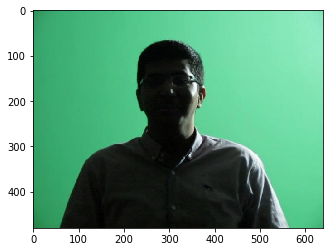

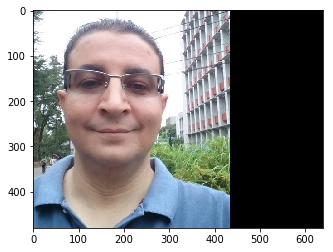

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
directory = '/content/original images'
path = directory
path_iter = os.listdir(directory)
count = 0
count1 = 0
for i in path_iter:
  input_img = cv2.imread(os.path.join(path,i),1) 
  input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
  x = i.split('_')
  x1 = x[0]+x[1]
  value = id_ill_pair[x1]
  plt.figure()
  if value == 0:
    count +=1
    if count <= 1:
      plt.imshow(input_img)
      continue
    else: 
      if count1 <= 1:
        continue
      else:
        break
  count1 += 1
  if count1 <= 1:
    plt.imshow(input_img)






Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



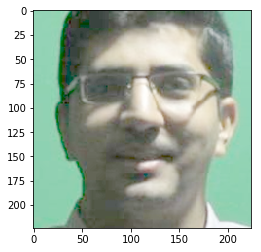

In [0]:
#count = 0
training_data = []
detector = MTCNN()
fa = FaceAligner(detector, desiredFaceWidth=224)
for i in path_iter:
  x = i.split('_')
  x1 = x[0]+x[1]
  value = id_ill_pair[x1]
  if ( x[0] == 'MahA' or x[0] == 'MahM' ):
  #  count = count+1    
    input_img = cv2.imread(os.path.join(path,i),1)    
   # new_image = np.zeros(input_img.shape, input_img.dtype)
    if value == 0:
      gamma = 3.0
      alpha = 1.2
      beta = 2.4
      #input_img = cv2.imread(os.path.join(path,i),1) 
    #  input_img_1 = alphabeta(input_img,alpha,beta)
      input_img_2 = adjust_gamma(input_img, gamma=gamma)
      input_img_3 = cv2.cvtColor(input_img_2, cv2.COLOR_BGR2RGB)
      faceAligned = preProcessLoad(input_img_3,detector,fa)
      input_img_resize_1=cv2.resize(faceAligned,(224,224))
      ds1t = cv2.GaussianBlur(input_img_resize_1,(5,5),cv2.BORDER_DEFAULT)
      plt.imshow(faceAligned)
      training_data.append([ds1t,x[0]])
      training_data.append([input_img_resize_1 ,x[0]])
      continue
    input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    faceAligned = preProcessLoad(input_img,detector,fa)
    input_img_resize=cv2.resize(faceAligned,(224,224))
    dst = cv2.GaussianBlur(input_img_resize,(5,5),cv2.BORDER_DEFAULT)
    training_data.append([input_img_resize,x[0]])
    training_data.append([dst,x[0]])
  else:
    continue

In [0]:
len(training_data)

772

In [0]:
random.shuffle(training_data)

In [0]:
training_data[0]

[array([[[165, 221, 203],
         [165, 221, 203],
         [165, 221, 203],
         ...,
         [171, 224, 206],
         [171, 224, 206],
         [171, 224, 206]],
 
        [[165, 221, 203],
         [165, 221, 203],
         [165, 221, 203],
         ...,
         [171, 224, 206],
         [171, 224, 206],
         [171, 224, 206]],
 
        [[165, 221, 203],
         [165, 221, 203],
         [165, 221, 203],
         ...,
         [169, 224, 206],
         [170, 224, 206],
         [170, 224, 206]],
 
        ...,
 
        [[151, 213, 192],
         [151, 213, 192],
         [151, 213, 192],
         ...,
         [155, 214, 195],
         [154, 214, 194],
         [154, 214, 194]],
 
        [[153, 214, 193],
         [153, 214, 193],
         [153, 214, 193],
         ...,
         [153, 213, 194],
         [153, 213, 194],
         [153, 213, 194]],
 
        [[153, 214, 193],
         [153, 214, 193],
         [153, 214, 193],
         ...,
         [153, 213, 194],
  

In [0]:
label_1 = []
label_2 = []
for features,label in training_data: 
  if label == 'MahM':
    label_1.append([features,label])
  else:
    label_2.append([features,label])

In [0]:
label_1.remove(label_1[0])
label_2.remove(label_2[0])

In [0]:
print(len(label_1),len(label_2))

513 257


In [0]:
X = []
Y = []
for i in range(len(label_2)):
  X.append(label_1[i][0])
  Y.append(label_1[i][1])
  X.append(label_1[i+1][0])
  Y.append(label_1[i+1][1])
  X.append(label_2[i][0])
  Y.append(label_2[i][1])


In [0]:
X[0].shape

(224, 224, 3)

In [0]:
X[0]

array([[[143, 198, 171],
        [143, 198, 171],
        [143, 198, 171],
        ...,
        [150, 203, 178],
        [151, 204, 179],
        [150, 203, 178]],

       [[143, 198, 171],
        [143, 198, 171],
        [143, 198, 171],
        ...,
        [151, 204, 179],
        [151, 204, 179],
        [150, 203, 178]],

       [[141, 197, 170],
        [142, 197, 170],
        [142, 197, 170],
        ...,
        [151, 204, 179],
        [150, 203, 178],
        [150, 203, 178]],

       ...,

       [[131, 131, 132],
        [133, 133, 135],
        [130, 130, 132],
        ...,
        [198, 211, 212],
        [196, 210, 210],
        [192, 208, 207]],

       [[131, 131, 134],
        [132, 132, 135],
        [129, 129, 132],
        ...,
        [206, 213, 216],
        [207, 214, 217],
        [206, 215, 217]],

       [[135, 135, 137],
        [134, 134, 137],
        [129, 129, 132],
        ...,
        [203, 206, 211],
        [206, 209, 214],
        [209, 213, 218]]

In [0]:
Y[0]

'MahM'

In [0]:
len(Y)

771

In [0]:
X = np.array(X).reshape(-1,224,224,3)
Y = np.array(Y)

In [0]:
X.shape

(771, 224, 224, 3)

In [0]:
X[0].shape

(224, 224, 3)

In [0]:
Y.shape

(771,)

In [0]:
LE = LabelEncoder()
Y = LE.fit_transform(Y)

In [0]:
Y.shape

(771,)

In [0]:
Y

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,

In [0]:
np.unique(Y)

array([0, 1])

In [0]:
def lossfunction(y_true, y_pred): 
    return batch_hard_triplet_loss(y_true, y_pred,margin=0.01)
   # return batch_all_triplet_loss(y_true, y_pred,margin=0.3)

In [0]:
inputs = Input(shape=(224,224,3))

conv_layer_1 = Conv2D(128, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
conv_layer_1 = MaxPooling2D(pool_size=(3,3), strides=(2, 2),padding='same')(conv_layer_1)
conv_layer_1 = BatchNormalization()(conv_layer_1)

inception_layer_1a = Conv2D(64,(1,1),padding='same')(conv_layer_1)
inception_layer_1a = Conv2D(128,(3,3),padding='same')(inception_layer_1a)
inception_layer_1b = Conv2D(64,(1,1),padding='same')(conv_layer_1)
inception_layer_1b = Conv2D(128,(5,5),padding='same')(inception_layer_1a)
inception_1 = concatenate([inception_layer_1a,inception_layer_1b])
inception_1 = BatchNormalization()(inception_1)
inception_1 = MaxPooling2D(pool_size=(3,3), strides=(2, 2),padding='same')(inception_1)

inception_layer_2a = Conv2D(64,(1,1),padding='same')(inception_1)
inception_layer_2b = Conv2D(96,(1,1),padding='same')(inception_1)
inception_layer_2b = Conv2D(192,(3,3),padding='same')(inception_layer_2b)
inception_layer_2c = Conv2D(16,(1,1),padding='same')(inception_1)
inception_layer_2c = Conv2D(64,(5,5),padding='same')(inception_layer_2c)
inception_layer_2d = MaxPooling2D((3,3),padding='same', strides=(1, 1))(inception_1)
inception_layer_2d = Conv2D(64,(1,1),padding='same')(inception_layer_2d)

inception_2 = concatenate([inception_layer_2a,inception_layer_2b,inception_layer_2c,inception_layer_2d])
inception_2 = BatchNormalization()(inception_2)

inception_layer_3a = Conv2D(128,(1,1),padding='same')(inception_2)
inception_layer_3a = Conv2D(256,(3,3),padding='same')(inception_layer_3a)
inception_layer_3a  = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception_layer_3a)
inception_layer_3b = Conv2D(64,(1,1),padding='same')(inception_2)
inception_layer_3b = Conv2D(128,(3,3),padding='same')(inception_layer_3b)
inception_layer_3b  = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception_layer_3b)
inception_layer_3c = Conv2D(32,(1,1),padding='same')(inception_2)
inception_layer_3c = Conv2D(64,(5,5),padding='same')(inception_layer_3c)
inception_layer_3c  = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception_layer_3c)
inception_layer_3d = Conv2D(32,(1,1),padding='same')(inception_2)
inception_layer_3d = Conv2D(64,(5,5),padding='same')(inception_layer_3d)
inception_layer_3d  = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception_layer_3d)

inception_3 = concatenate([inception_layer_3a,inception_layer_3b,inception_layer_3c,inception_layer_3d])
inception_3 = BatchNormalization()(inception_3)

inception_layer_4a = Conv2D(256,(1,1),padding='same')(inception_3)
inception_layer_4b = Conv2D(96,(1,1),padding='same')(inception_3)
inception_layer_4b = Conv2D(256,(3,3),padding='same')(inception_layer_4b)
inception_layer_4c = Conv2D(96,(1,1),padding='same')(inception_3)
inception_layer_4c = Conv2D(128,(5,5),padding='same')(inception_layer_4c)

inception_4 = concatenate([inception_layer_4a,inception_layer_4b,inception_layer_4c])
inception_4 = BatchNormalization()(inception_4)


inception_layer_5a = Conv2D(256,(1,1),padding='same')(inception_4)
inception_layer_5a  = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception_layer_5a)
inception_layer_5b = Conv2D(128,(1,1),padding='same')(inception_4)
inception_layer_5b = Conv2D(256,(3,3),padding='same')(inception_layer_5b)
inception_layer_5b  = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception_layer_5b)
inception_layer_5c = Conv2D(64,(1,1),padding='same')(inception_4)
inception_layer_5c = Conv2D(128,(5,5),padding='same')(inception_layer_5c)
inception_layer_5c  = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception_layer_5c)
inception_layer_5d = Conv2D(64,(1,1),padding='same')(inception_4)
inception_layer_5d = Conv2D(128,(3,3),padding='same')(inception_layer_5d)
inception_layer_5d  = MaxPooling2D((3,3),padding='same', strides=(2, 2))(inception_layer_5d)

inception_5 = concatenate([inception_layer_5a,inception_layer_5b,inception_layer_5c,inception_layer_5d])
inception_5 = BatchNormalization()(inception_5)


inception_layer_6a = Conv2D(384,(1,1),padding='same')(inception_5)
inception_layer_6b = Conv2D(192,(1,1),padding='same')(inception_5)
inception_layer_6b = Conv2D(384,(3,3),padding='same')(inception_layer_6b)
inception_layer_6c = Conv2D(192,(1,1),padding='same')(inception_5)
inception_layer_6c = Conv2D(384,(3,3),padding='same')(inception_layer_6c)
inception_layer_6d = Conv2D(64,(1,1),padding='same')(inception_5)
inception_layer_6d = Conv2D(128,(5,5),padding='same')(inception_layer_6d)
inception_layer_6e = Conv2D(64,(1,1),padding='same')(inception_5)
inception_layer_6e = Conv2D(128,(7,7),padding='same')(inception_layer_6e)

inception_6 = concatenate([inception_layer_6a,inception_layer_6b,inception_layer_6c,inception_layer_6d,inception_layer_6e])
#inception_6 = BatchNormalization()(inception_6)

avg_pooling = AveragePooling2D(pool_size=(7, 7))(inception_6)
avg_pooling = Flatten()(avg_pooling)

Outputs = Dense(128,kernel_regularizer=regularizers.l2(0.01))(avg_pooling)

model = Model(input=inputs,output=Outputs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 128 18944       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 128)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 56, 56, 128)  512         max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss=lossfunction, metrics=["accuracy"])


Instructions for updating:
Use `tf.cast` instead.


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [0]:
epochs = 50
model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=36),
                    steps_per_epoch=len(X_train) / 36, epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
11/10 [==============================] - 14s 1s/step - loss: 18.2611 - acc: 0.0025
Epoch 2/50
11/10 [==============================] - 6s 545ms/step - loss: 6.8768 - acc: 0.0000e+00
Epoch 3/50
11/10 [==============================] - 6s 544ms/step - loss: 4.4456 - acc: 0.0000e+00
Epoch 4/50
11/10 [==============================] - 6s 535ms/step - loss: 3.8091 - acc: 0.0000e+00
Epoch 5/50
11/10 [==============================] - 6s 543ms/step - loss: 3.3582 - acc: 0.0000e+00
Epoch 6/50
11/10 [==============================] - 6s 548ms/step - loss: 2.9599 - acc: 0.0000e+00
Epoch 7/50
11/10 [==============================] - 6s 536ms/step - loss: 2.7415 - acc: 0.0061
Epoch 8/50
11/10 [==============================] - 6s 549ms/step - loss: 2.5490 - acc: 0.0000e+00
Epoch 9/50
11/10 [==============================] - 6s 541ms/step - loss: 2.4450 - acc: 0.0000e+00
Epoch 10/50
11/10 [=====

In [0]:
test_datagen = ImageDataGenerator(
    samplewise_center= True,
    samplewise_std_normalization=True)

In [0]:
test_generator = test_datagen.flow(X_test)

In [0]:
embeddings = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

13/13 [==============================] - 3s 231ms/step


In [0]:
embeddings.shape

(386, 128)

In [0]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(embeddings, y_test, test_size=0.3)

In [0]:
print(X_train1.shape,y_train1.shape)

(270, 128) (270,)


In [0]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train1, y_train1) 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
print(X_test1.shape,y_test1.shape)

(116, 128) (116,)


In [0]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.7327586206896551

In [0]:
model.save('final_model_2.h5')

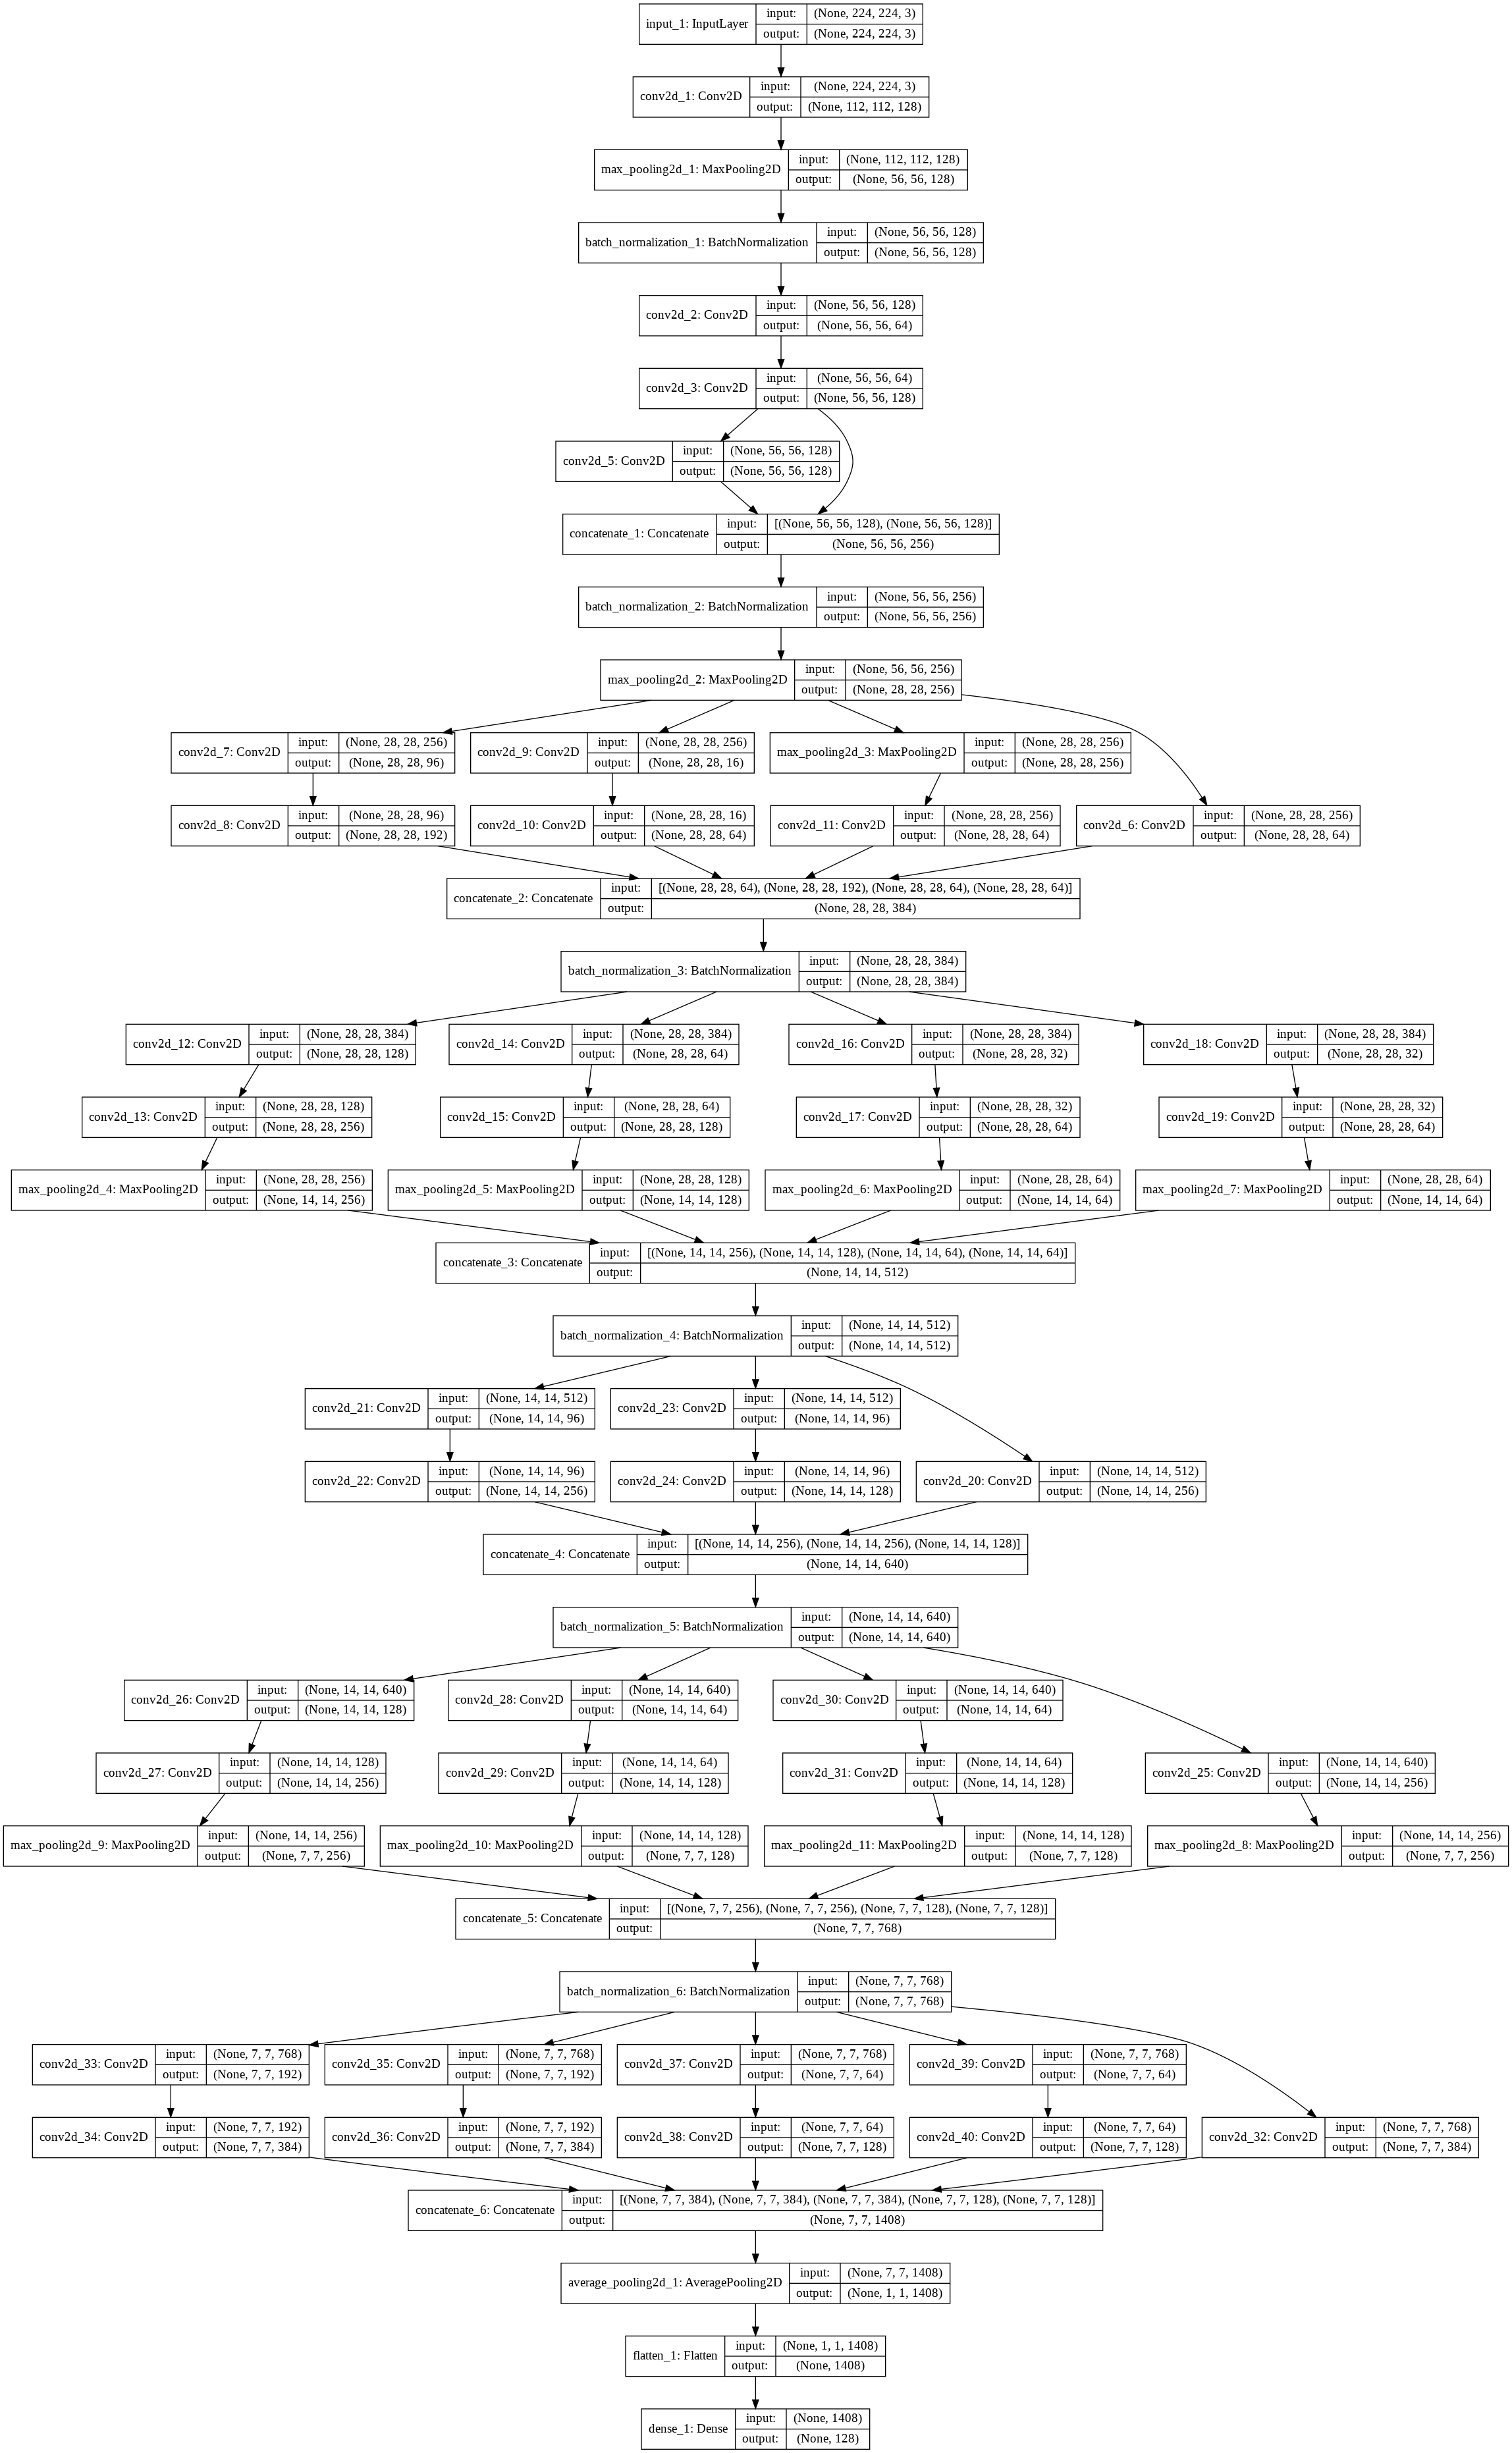

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)